# Turbidity Dilutions 4/09/2023

## Cuvette Holder 3D Design
This 3D design for the cuvette holder involved using a 2:1 ratio for the hole to channel ratio for the LED/AS7341 to the cuvette. The hole opening for both the LED and AS7341 is 5.0mm in diameter with a 10mm channel in length to the cuvette itself. This design positions the LED and AS7341 at a 90 degree angle from one another. There are two LED holes. One for the blue LED light and the other for the IR light. In this test the IR LED light is used for turbidity measurements. 

Design materials can be found at: https://github.com/jessiewynne/Chlorophyll-Fluorometer-/tree/main/Hardware/Cuvette%20Holder/Through%20Hole%20Designs

Water-resistant housign was constucted for the cuvette holder which can be found at: 
An opague cap was constructed for the housing to cover the cuvette and eliminate ambient light. 

## Dilutions 
The AS7341 sensor underwent serial dilutions of Formazin standards. A Formazin solution of 4000 FNU was obtained from: www.Hatch.com. This solution was diluted with DI water to solutions of 0-700 FNU for testing of the turbidity portion of the low-cost multiparameter sensor. 

Dilutions were all completed for one minute for each dilution value at a gain of 128x, and an integration time of 700ms.  

During these dilutions the AS7341 sensor and housing was put under a cardboard box as to eliminate any ambient light interference. 

## LED placement 
The LED was secured in the design using marine grade epoxy to eliminate any movement. 

# Code for Dilution Results

/var/folders/2t/y2hq763j57s74t5t6v0r2vm40000gn/T/ipykernel_7618/3164030592.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_no_first = df.groupby('Test').apply(lambda group: group.iloc[1:])


17742.50194552529
18958.843565183448
Mean for '0': 1435.9000
Standard Deviation for '0': 1.9974
Mean for '2.5': 1412.8421
Standard Deviation for '2.5': 1.4630
LoB: 1439.1857
LoD: 1441.5923
SD Low Concentration Sample: 1.4630


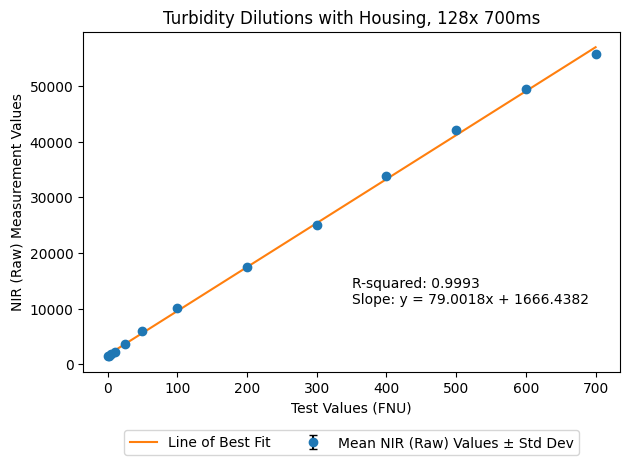

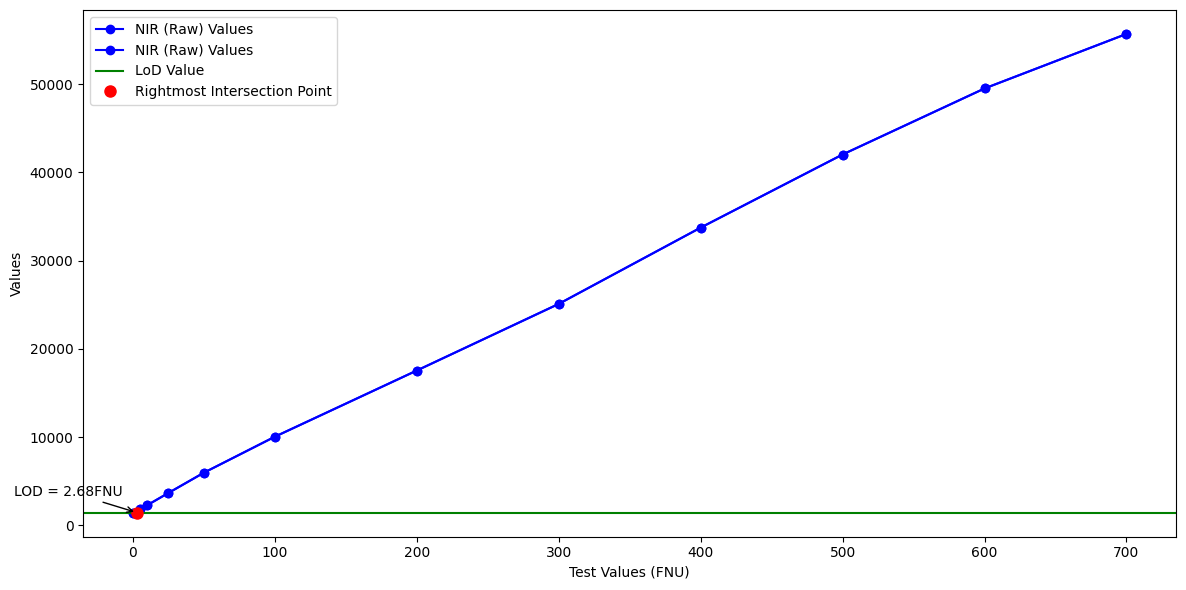

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress, t
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd

# Replace with the actual file path
file_path = "/Users/jessiewynne/housing_turb_dilutions_4_16_24.csv"
# Read the CSV file without skipping any rows

df = pd.read_csv(file_path, encoding='utf-8')

# Filter out rows where the 'Test' column is 'test'
df = df[df['Test'].str.lower() != 'test'] 

# Convert 'F8 (Raw)' column to numeric values
df['NIR (Raw)'] = pd.to_numeric(df['NIR (Raw)'], errors='coerce')

# Get unique test categories (dilution values) in the order of appearance
categories = df['Test'].unique()

# Create a dictionary to store the 'F8 (Raw)' values for each category (dilution)
category_NIR_raw_dict = {}

# Create dictionaries to store confidence intervals and ranges of uncertainty
confidence_intervals = {}
uncertainty_ranges = {}
lobs = {}  # To store LoB values
lods = {}  # To store LoD values

# Initialize mean_blank before the loop
mean_blank = 0

# Store unique x-values and their corresponding data points
x_values = []
y_values = []
std_devs = []

for category in categories:
    # Exclude the first data point from each category
    category_df = df[df['Test'] == category][1:]
    category_NIR_raw_dict[category] = category_df['NIR (Raw)']

    # Calculate the mean and standard deviation for 'F8 (Raw)' data in each category
    category_NIR_raw_mean = category_df['NIR (Raw)'].mean()
    category_NIR_raw_std = category_df['NIR (Raw)'].std()
    # print(category_f8_raw_mean)

    # Calculate the sample size for each category
    category_sample_size = len(category_df['NIR (Raw)'])

    # Calculate the standard error for each category's mean
    category_standard_error = category_NIR_raw_std / np.sqrt(category_sample_size)

    # Define the confidence level (e.g., 95%)
    confidence_level = 0.95

    # Calculate the margin of error using the t-distribution
    margin_of_error = t.ppf((1 + confidence_level) / 2, category_sample_size - 1) * category_standard_error

    # Calculate the confidence interval for each category's mean
    confidence_interval = (category_NIR_raw_mean - margin_of_error, category_NIR_raw_mean + margin_of_error)

    # Calculate the range of uncertainty (95% CI width) for each category
    uncertainty_range = confidence_interval[1] - confidence_interval[0]

    # Check if the 'Test' value can be converted to a float, otherwise, skip it
    try:
        x_value = float(category)
        x_values.append(x_value)
        y_values.append(category_NIR_raw_mean)
        std_devs.append(category_NIR_raw_std)
    except ValueError:
        pass

# Exclude the first data point from each trial
df_no_first = df.groupby('Test').apply(lambda group: group.iloc[1:])

# Calculate the mean and standard deviation for the entire dataset for 'F8 (Raw)' data
dataset_NIR_raw_mean = df['NIR (Raw)'].mean()
dataset_NIR_raw_std = df['NIR (Raw)'].std()
print(dataset_NIR_raw_mean)
print(dataset_NIR_raw_std)

# Calculate the sample size for the entire dataset
dataset_sample_size = len(df['NIR (Raw)'])

# Calculate the standard error for the entire dataset's mean
dataset_standard_error = dataset_NIR_raw_std / np.sqrt(dataset_sample_size)

# Calculate the margin of error using the t-distribution
confidence_level = 0.95
margin_of_error = t.ppf((1 + confidence_level) / 2, dataset_sample_size - 1) * dataset_standard_error

# Calculate the confidence interval for the entire dataset's mean
confidence_interval = (dataset_NIR_raw_mean - margin_of_error, dataset_NIR_raw_mean + margin_of_error)

# Calculate the range of uncertainty (95% CI width) for the entire dataset
uncertainty_range = confidence_interval[1] - confidence_interval[0]

# Calculate the minimum and maximum 'F8 (Raw)' values for each test category
min_NIR_values = {}
max_NIR_values = {}
for category, NIR_raw_values in category_NIR_raw_dict.items():
    min_NIR_values[category] = NIR_raw_values.min()
    max_NIR_values[category] = NIR_raw_values.max()


# Scatter plot for mean F8 values with error bars and legend
plt.errorbar(x_values, y_values, yerr=std_devs, fmt='o', capsize=3, ecolor='black', label='Mean NIR (Raw) Values ± Std Dev')

# Calculate the line of best fit parameters (slope and intercept)
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

# Create a function to calculate predicted values using the line of best fit equation
def predict_values(x, slope, intercept):
    return slope * x + intercept

# Plot the line of best fit
plt.plot(x_values, predict_values(np.array(x_values), slope, intercept), label='Line of Best Fit')

# Calculate R-squared and RMSE
y_predicted = predict_values(np.array(x_values), slope, intercept)
r_squared = r2_score(y_values, y_predicted)
rmse = np.sqrt(mean_squared_error(y_values, y_predicted))

# Set x-axis tick positions at intervals of 5
plt.xticks(np.arange(min(x_values), max(x_values)+1, 100))

plt.xlabel('Test Values (FNU)')
plt.ylabel('NIR (Raw) Measurement Values')
plt.legend(loc='upper center', bbox_to_anchor=(0.50, -0.15), ncol=2)  # Move legend down and adjust layout
# plt.title("AS7341 Dilutions 256x Gain, 700ms Integration")
plt.annotate(f'R-squared: {r_squared:.4f}\nSlope: y = {slope:.4f}x + {intercept:.4f}', xy=(0.50, 0.20), xycoords='axes fraction')
plt.title("Turbidity Dilutions with Housing, 128x 700ms")

# # Display R-squared, RMSE, slope, and y-intercept on the plot
# plt.annotate(f'R-squared: {r_squared:.4f}\nSlope: y = {slope:.4f}x + {intercept:.4f}', xy=(0.05, 0.85), xycoords='axes fraction')

plt.tight_layout()



# Calculate mean and standard deviation for category '0.0' (blank) excluding the first measurement
category_0_0_df = df[df['Test'] == '0'][1:]
mean_blank = category_0_0_df['NIR (Raw)'].mean()
sd_blank = category_0_0_df['NIR (Raw)'].std()

# Print mean and standard deviation for '0.0' category
print(f"Mean for '0': {mean_blank:.4f}")
print(f"Standard Deviation for '0': {sd_blank:.4f}")

# Calculate LoB for category '0.0' excluding the first measurement
lob = mean_blank + 1.645 * sd_blank

# Calculate mean and standard deviation for category '0.25' (low concentration sample) excluding the first measurement
category_0_25_df = df[df['Test'] == '2.5'][1:]
sd_low_concentration_sample = category_0_25_df['NIR (Raw)'].std()

# Print mean and standard deviation for '0.25' category
print(f"Mean for '2.5': {category_0_25_df['NIR (Raw)'].mean():.4f}")
print(f"Standard Deviation for '2.5': {sd_low_concentration_sample:.4f}")

# Calculate LoD for category '0.25' excluding the first measurement
lod = lob + 1.645 * sd_low_concentration_sample

# Print LoB, LoD, and sd_low_concentration_sample values
print(f"LoB: {lob:.4f}")
print(f"LoD: {lod:.4f}")
print(f"SD Low Concentration Sample: {sd_low_concentration_sample:.4f}")


# Create a second figure for LoD values and F8 values vs. test categories
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed



# Plot F8 (Raw) values against test values (all categories)
plt.plot(x_values, y_values, marker='o', linestyle='-', color='blue', label='NIR (Raw) Values')

# Calculate the slope and intercept of the F8 values line
slope_NIR_values = slope  # slope from the line of best fit
intercept__values = intercept  # intercept from the line of best fit

# Assuming x_values contains your test values and lod is the singular LoD value

# List to store intersection points
intersection_points = []

# Initialize variables to track the rightmost LoD intersection point
max_intersection_x = float('-inf')
rightmost_intersection_point = None

# Calculate intersection points for the singular LoD value
for i in range(len(x_values) - 1):
    x1, x2 = x_values[i], x_values[i + 1]
    y1, y2 = y_values[i], y_values[i + 1]
    
    # Check if the LoD value is between the y-values of two adjacent x-values
    if min(y1, y2) <= lod <= max(y1, y2):
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
        intersection_x = (lod - intercept) / slope

        # Update the rightmost intersection point
        if intersection_x > max_intersection_x:
            max_intersection_x = intersection_x
            rightmost_intersection_point = (intersection_x, lod)

# Plot F8 (Raw) values against test values
plt.plot(x_values, y_values, marker='o', linestyle='-', color='blue', label='NIR (Raw) Values')
# # Plot the line of best fit
# plt.plot(x_values, np.array(x_values) * slope + intercept, label='Line of Best Fit')
# Plot LoD line and the rightmost intersection point
plt.axhline(y=lod, color='green', linestyle='-', label='LoD Value')
plt.plot([rightmost_intersection_point[0]], [rightmost_intersection_point[1]], marker='o', markersize=8, color='red', linestyle='None', label='Rightmost Intersection Point')

# Annotate the rightmost intersection point on the graph
plt.annotate(f'LOD = {rightmost_intersection_point[0]:.2f}FNU', 
             xy=rightmost_intersection_point, xycoords='data',
             xytext=(-10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"),
             horizontalalignment='right', verticalalignment='bottom')

plt.xlabel('Test Values (FNU)')
plt.ylabel('Values')
# Set grid color to lighter gray and linestyle to dashed
plt.grid(color='none')

# Move the annotation down by adjusting the y-coordinate
# plt.annotate(f'R-squared: {r_squared:.4f}\nSlope: y = {slope:.4f}x + {intercept:.4f}', xy=(0.05, 0.75), xycoords='axes fraction')
plt.legend()
plt.tight_layout()
plt.title("")
plt.show()